# Converting karst map to a node/link directed graph #

In [1]:
#General imports
import os            
import sys           
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#all fast-marching-related imports
import agd
from agd import Eikonal

#pykasso import
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

icost shape (80, 100, 5)
0 [535.   5.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
1 [375. 525.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.01 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
2 [125. 285.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.007 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
3 [145. 585.]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 

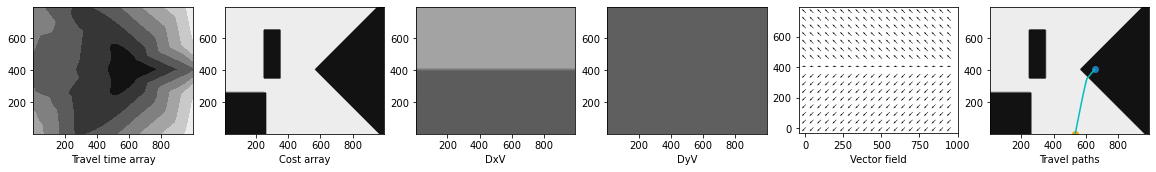

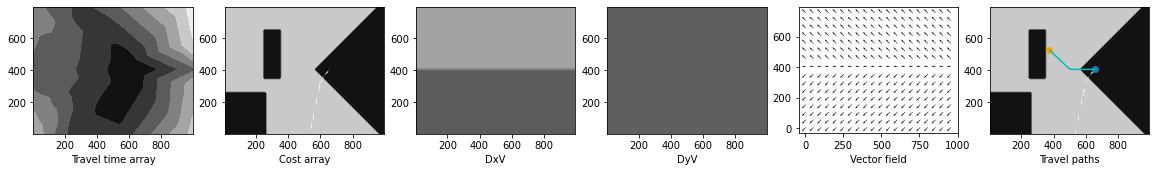

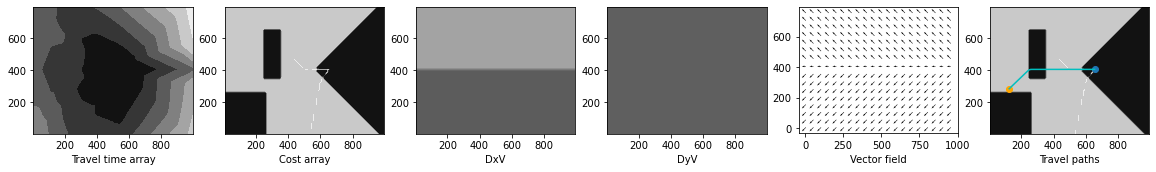

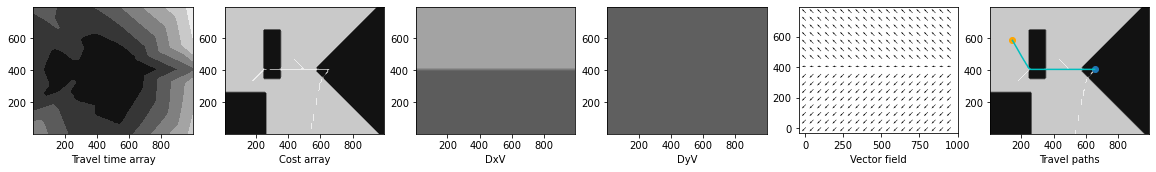

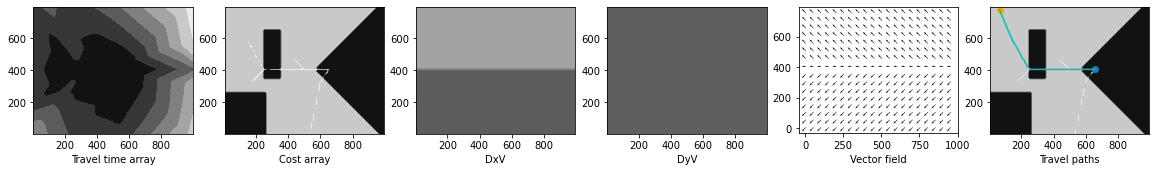

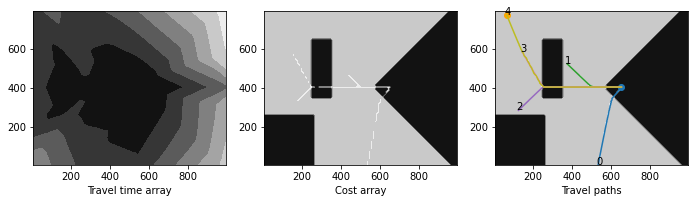

In [5]:
#Run model manually (outside of pykasso but using same steps) to be able to check every step

#THIS IS THE REFERENCE - DO NOT CHANGE

#Load inputs
#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0
hfmIn = agd.Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])  #hfm library grid is flipped
X,Y = hfmIn.Grid()  #get model grid
dem = np.genfromtxt("inputs/valley1/dem80x100.csv", delimiter=',')  #2D topography array
geo = np.genfromtxt("inputs/valley1/geo80x100.csv", delimiter=',')  #2D geology array
inlets  = np.genfromtxt("inputs/valley1/inlets.txt",  delimiter=' ')  #import as csv
outlets = np.asarray([np.genfromtxt("inputs/valley1/outlets.txt", delimiter=' ')])  #import as csv - have to wrap in an array if only a single value, otherwise indexing won't work

#Assign cost values
Cout      = 0.999  #travel cost in areas outside model bound (should be very high)
Ckarst    = 0.3    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.8   #changed to be higher based on Test #3
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full(geo.shape, Ckarst) #set up array of default alpha values
cost[np.isnan(geo)] = Cout        #assign very high cost to out of bounds
cost[geo==2]        = Ckarst      #assign low cost to limestone (2)
cost[geo!=2]        = Cnonkarst   #assign medium-high cost to all non-karst units

#Run iterations
icost   = np.repeat(cost[:,:,np.newaxis], len(inlets), axis=2)  #repeat cost arrays for each iteration
print('icost shape', icost.shape)
network = []
for i,inlet in enumerate(inlets):
    print(i,inlet)
    # Create a model object and define the domain:
    hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
    Y,X = hfmIn.Grid()  #get model grid
        
    #Calculate the gradients:
    DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
    alpha = icost[:,:,i]                               #travel cost in same direction as gradient
    Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
    beta  = alpha / Cratio      #travel cost perpendicular to gradient (should be higher than parallel cost) 
    F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)
    hfmIn['metric'] = F  #set the travel cost through each cell
    hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tip']    = inlet[[1,0]]    #set the inlet coordinates 

    #Run & get outputs:
    hfmOut = hfmIn.Run()
    time = hfmOut['values']
    paths = hfmOut['geodesics']
    network.append(paths)
    
    #Update cost array to have lower cost in conduits:
    if i < len(inlets)-1:
        for path in paths:                     #loop over paths (if more than one per iteration)
            for p in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
                point = path[:,p]          
                [[ix,iy],error]  = hfmIn.IndexFromPoint(point) #convert to indices
                icost[ix,iy,i+1:] = Cconduit
    
    #Plot
    f = plt.figure(figsize=(20,5))
    f.add_subplot(161, aspect='equal')
    plt.xlabel('Travel time array')
    plt.contourf(X,Y,time, cmap='gray')
    
    f.add_subplot(162, aspect='equal')
    plt.xlabel('Cost array')
    plt.contourf(X,Y,alpha, cmap='gray_r')
    
    f.add_subplot(163, aspect='equal')
    plt.xlabel('DxV')
    plt.contourf(X,Y, DxV, cmap = 'gray', vmin=-1, vmax=1)
    
    f.add_subplot(164, aspect='equal')
    plt.xlabel('DyV')
    plt.contourf(X,Y, DyV, cmap = 'gray', vmin=-1,vmax=1)
    
    f.add_subplot(165, aspect='equal')
    plt.xlabel('Vector field')
    skip=(slice(None,None,5),slice(None,None,5))
    plt.quiver(X[skip], Y[skip], DyV[skip], DxV[skip], scale=10)
    
    f.add_subplot(166, aspect='equal')
    plt.xlabel('Travel paths')
    plt.contourf(X,Y, alpha, cmap='gray_r')
    plt.scatter(hfmIn['tip'][1],  hfmIn['tip'][0], c='orange')
    plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c='c')
        
f2 = plt.figure(figsize=(20,5))
f2.add_subplot(151, aspect='equal')
plt.xlabel('Travel time array')
plt.contourf(X,Y,time, cmap='gray')

f2.add_subplot(152, aspect='equal')
plt.xlabel('Cost array')
plt.contourf(X,Y,alpha, cmap='gray_r')

f2.add_subplot(153, aspect='equal')
plt.xlabel('Travel paths')
plt.contourf(X,Y, alpha, cmap='gray_r')
plt.scatter(hfmIn['tips'][:,1],  hfmIn['tips'][:,0], c='orange')
plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
for i,inlet in enumerate(inlets):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(network):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))

0 [535.   5.]
1 [375. 525.]
2 [125. 285.]
3 [145. 585.]
4 [ 65. 775.]


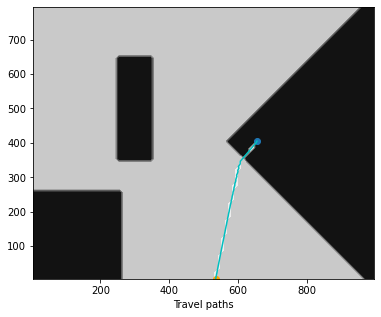

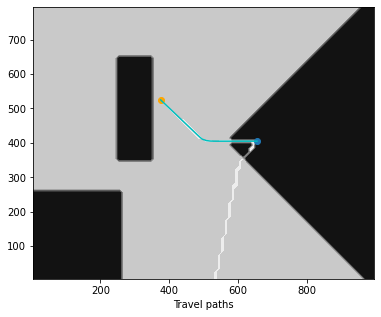

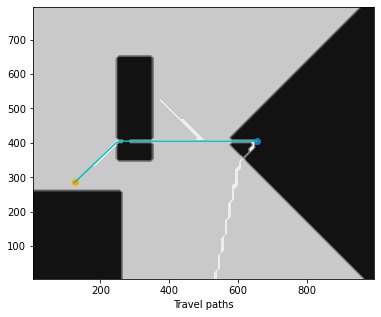

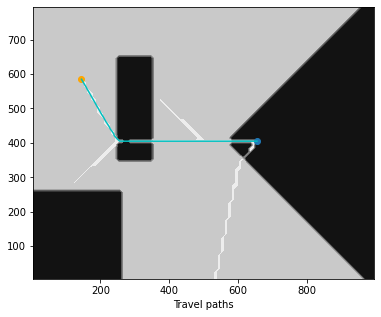

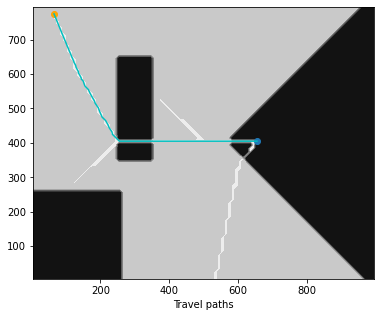

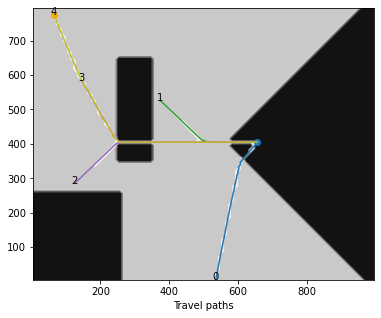

In [19]:
#MAKE CHANGES HERE

#Load inputs
#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0
hfmIn = agd.Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])  #hfm library grid is flipped
X,Y = hfmIn.Grid()  #get model grid
dem = np.genfromtxt("inputs/valley1/dem80x100.csv", delimiter=',')  #2D topography array
geo = np.genfromtxt("inputs/valley1/geo80x100.csv", delimiter=',')  #2D geology array
inlets  = np.genfromtxt("inputs/valley1/inlets.txt",  delimiter=' ')  #import as csv
outlets = np.asarray([np.genfromtxt("inputs/valley1/outlets.txt", delimiter=' ')])  #import as csv - have to wrap in an array if only a single value, otherwise indexing won't work

#Assign cost values
Cout      = 0.999  #travel cost in areas outside model bound (should be very high)
Ckarst    = 0.3    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.8   #changed to be higher based on Test #3
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full(geo.shape, Ckarst) #set up array of default alpha values
cost[np.isnan(geo)] = Cout        #assign very high cost to out of bounds
cost[geo==2]        = Ckarst      #assign low cost to limestone (2)
cost[geo!=2]        = Cnonkarst   #assign medium-high cost to all non-karst units

#Make outlet location map
phi = np.zeros(geo.shape)   #set array of zeroes
for outlet in outlets:      #iterate over outlets
    [[ix,iy],error]  = hfmIn.IndexFromPoint(outlet) #convert outlet coordinates to indices
    phi[iy,ix] = -1         #set value at outlet locations to -1

#Run iterations
icost   = np.repeat(cost[:,:,np.newaxis], len(inlets), axis=2)  #repeat cost arrays for each iteration
network = []   #empty list to store paths from each iteration
nodes   = {}   #empty dic to store nodes
edges   = {}   #empty dic to store edges
n       = 0    #start node counter at zero
e       = 0    #start edge counter at zero
for i,inlet in enumerate(inlets):
    print(i,inlet)
    if i > 0:    #if not the first iteration
        icost[:,:,i] = icost[:,:,i-1]   #current cost map is cost map from previous iteration
    # Create a model object and define the domain:
    hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
    Y,X = hfmIn.Grid()  #get model grid
        
    #Calculate the gradients:
    DxV,DyV = np.gradient(dem, dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
    alpha = icost[:,:,i]                               #travel cost in same direction as gradient
    Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
    beta  = alpha / Cratio      #travel cost perpendicular to gradient (should be higher than parallel cost) 
    F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)
    hfmIn['metric'] = F  #set the travel cost through each cell
    hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tip']    = inlet[[1,0]]    #set the inlet coordinates 
    hfmIn['verbosity'] = 0            #set verbosity to 0 to suppress printing

    #Run & get outputs:
    hfmOut = hfmIn.Run()
    time = hfmOut['values']
    paths = hfmOut['geodesics']
    network.append(paths)
    
    #Update cost array to have lower cost in conduits, and make nodes/edges list:
    for path in paths:                     #loop over paths (if more than one per iteration)
        for p in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
            point = path[:,p]                              #get current point coordinates
            [[ix,iy],error]  = hfmIn.IndexFromPoint(point) #convert to indices

            if phi[ix,iy]  == -1:                          #if there is an outlet here
                pass
            if icost[ix,iy,i] == Cconduit:                   #if there is already a conduit here (can also use karst map for this)
                pass
            else:                                          #if there is no conduit or outlet here
                nodes[n] = [point]                         #add a node here
                edges[e] = 
                n = n+1                                    #increment counter up by one
                e = e+1
            print(nodes)
            print(edges)
            icost[ix,iy,i] = Cconduit                       #update current cost map with conduit
    
    #Plot
    f = plt.figure(figsize=(20,5))
    f.add_subplot(111, aspect='equal')
    plt.xlabel('Travel paths')
    plt.contourf(X,Y, alpha, cmap='gray_r')
    plt.scatter(hfmIn['tip'][1],  hfmIn['tip'][0], c='orange')
    plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c='c')
        
f2 = plt.figure(figsize=(20,5))
f2.add_subplot(111, aspect='equal')
plt.xlabel('Travel paths')
plt.contourf(X,Y, alpha, cmap='gray_r')
plt.scatter(hfmIn['tips'][:,1],  hfmIn['tips'][:,0], c='orange')
plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
for i,inlet in enumerate(inlets):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(network):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))

In [16]:
hfmIn.RunHelp()

Help on function RunSmart in module agd.Eikonal.run_detail:

RunSmart(hfmIn, co_output=None, cache=None, returns='out')
    Calls the HFM library, a CPU eikonal solver written in C++,
    with pre-processing and post-processing of data.
    
    Main input : 
    - hfmIn, a dictionary like structure, containing the eikonal solver data.
    
    The C++ library embeds some help information, which can be accessed using the 
    following key:value pairs in hfmIn.
    * 'verbosity' : set to 1 or 2 to display information on run, including the defaulted keys.
     set to 0 to silence the run.
    * 'keyHelp' : set as a string of keys separated by spaces, to print help on these.
     example 'keyHelp':"seeds tips"
    
    Optional input:
    - co_output (optional) : used for reverse automatic differentiation.
    - cache (optional) : store some intermediate results to bypass computations at a later stage. 
    - returns (optional) : early aborts the run (debug purposes). ('in_raw','out_raw'